Configurtion Register: 0x0
ADT7320 ID Register: 0xc3
Tcrit Setpoint     : 147.0 C
Thigh Setpoint     : 64.0 C
Tlow Setpoint      : 10.0 C
Thyst Setpoint     : 5 C

Raw Temp Value: 0x11e8
Temperature: 35.8125 C


<IPython.core.display.Javascript object>


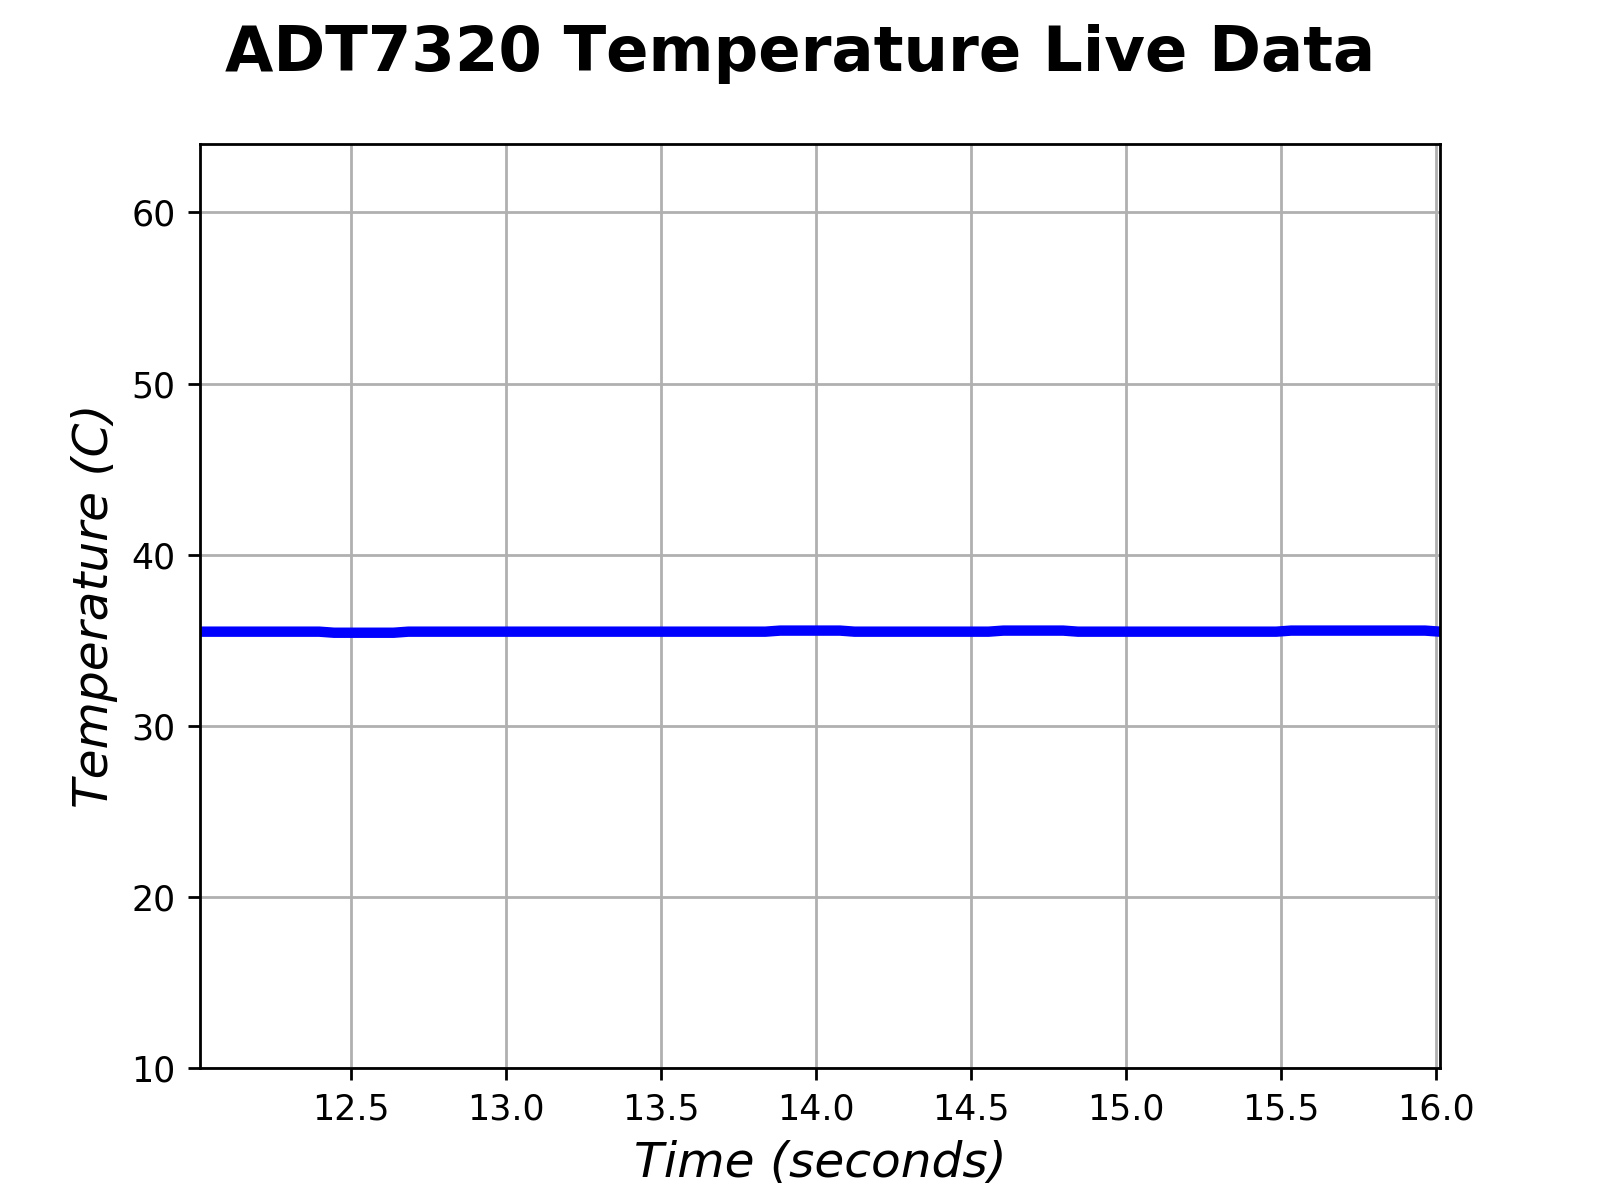

<IPython.core.display.Javascript object>


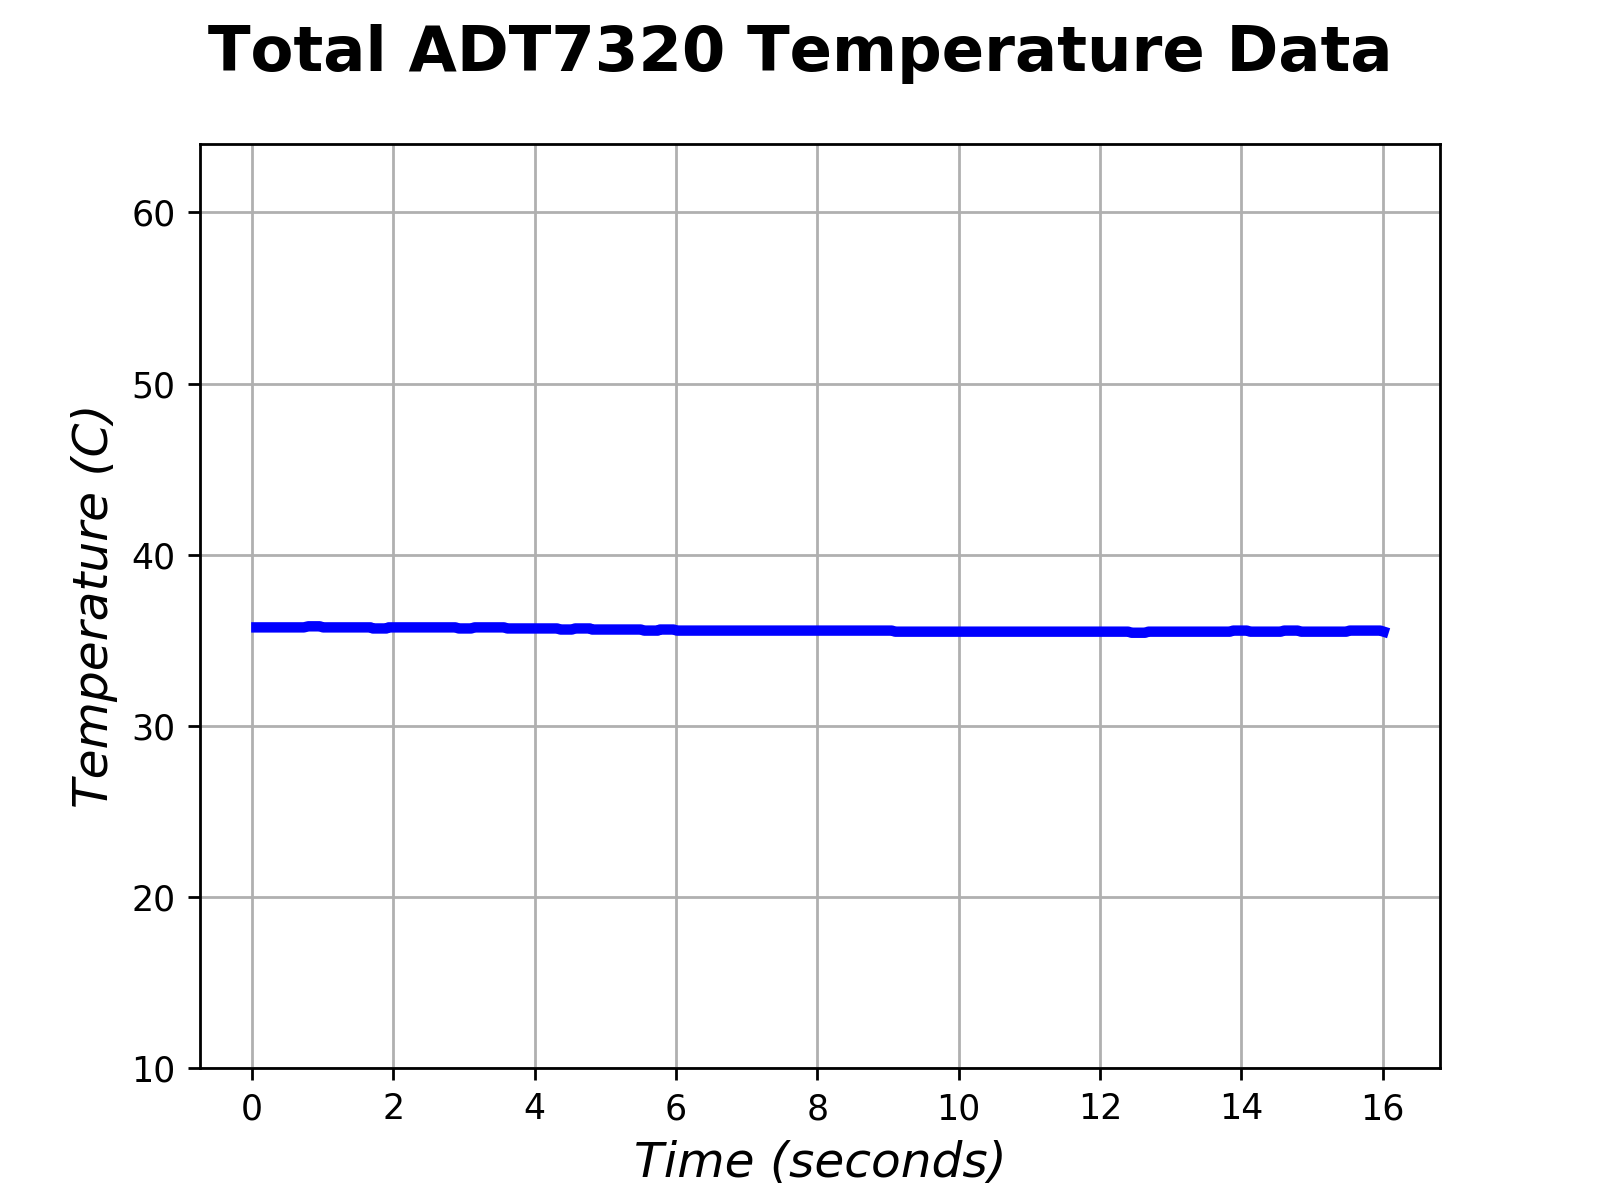

In [4]:
#
# Temperature Sensor Demo
#
%matplotlib notebook

import serial
import numpy as np
from matplotlib import pyplot as plt
from time import time

#
# Please change here to proper COM port name
#
ser = serial.Serial('COM11', 115200)
#
# ADT7320 register access functions
#
def ADT7320_read_reg8(reg):
    ser.reset_input_buffer()
    cmd = "<%0.2x..>" % (reg*8 + 64)  # 
    ser.write(bytearray(cmd,'utf8'))  # Send read register command
    s = ser.read(2)                   # Read data byte
    return int(s,16)                  # return unsigned 8 bit int

def ADT7320_read_reg16(reg):
    ser.reset_input_buffer()
    cmd = "<%0.2x....>" % (reg*8 + 64) # 
    ser.write(bytearray(cmd,'utf8'))   # Send read register command
    s = ser.read(4)                    # Read two data bytes
    x = int(s,16)                      # Convert hex to int
    if x > 32768: x = x - 65536        # Convert to signed int
    return x    

ser.flushInput() # flush the input
ser.reset_input_buffer() # reset the serial input buffer

ser.write(b'[1]')    # Select UHSA ADT Channel

# default configuration mode used - no configuration writes
# [1:0] Fault Queque = '00' = single fault
# [2] CT Pin Polarity = '0' = active low
# [3] INT Pin Polarity = '0' = active low
# [4] INT/CT Mode = '0' = interrupt mode
# [6:5] Operation Mode = '00' = continuous conversion
# [7] Resolution = '0' = 13-bit resolution. Sign bit + 12 bits gives a temperature resolution of 0.0625°C

# Diagnostics
# reading configuration, ID, and setpoint registers - all set to default values at powerup
print("Configurtion Register:", hex(ADT7320_read_reg8(1)))
print("ADT7320 ID Register:", hex(ADT7320_read_reg8(3)))
print("Tcrit Setpoint     :", ADT7320_read_reg16(4)/128, "C")
print("Thigh Setpoint     :", ADT7320_read_reg16(6)/128, "C")
print("Tlow Setpoint      :", ADT7320_read_reg16(7)/128, "C")
print("Thyst Setpoint     :", ADT7320_read_reg8(5), "C")
#
#
print("")
temp = ADT7320_read_reg16(2) # reading 13-bit two's complement temperature value
print("Raw Temp Value:",hex(temp)) # showing raw temperature bit value
temp = (temp >> 3)/16 # 13-bit temperature reading removing 3 LSBs status bits and dividing by 16 according to datasheet
print("Temperature:", round(temp, 1), "C") # showing rounded temperature to one decimal place
 
# start of plotting
plt.ion() 
start_time = time()
timepoints = []
ydata = []

yrange = [10.0, 64.0] # y limits set to default temperature limits
view_time = 4 # seconds of data to view at once
duration = 16 # total seconds to collect data

# plotting data for each 'view_time' window
fig1 = plt.figure()
fig1.suptitle('ADT7320 Temperature Live Data', fontsize='18', fontweight='bold')
plt.axes().grid(True)
plt.xlabel('Time (seconds)', fontsize='14', fontstyle='italic')
plt.ylabel('Temperature (C)', fontsize='14', fontstyle='italic')

# plotting and storing data
line1, = plt.plot(ydata, color="blue", linewidth=3.0)

# setting x and y axis limits
plt.ylim(yrange)
plt.xlim([0,view_time])

ser.flushInput() # flush serial input buffer
ser.reset_input_buffer() # reset serial input buffer

# setting 'run' boolean to True to enable plotting
run = True

# collect the data and plot a moving frame
while run:
    # 
    try:
        # reading MSB 13 bits from temperature register
        y = ADT7320_read_reg16(2)
        y = (y >> 3)/16

        # store the entire dataset for later
        ydata.append(y)
        
        # storing timepoints for y axis plot
        timepoints.append(time()-start_time)
        current_time = timepoints[-1]
        
        # update the plotted data
        line1.set_xdata(timepoints)
        line1.set_ydata(ydata)
        
        # slide the viewing frame along
        if current_time > view_time:
            plt.xlim([current_time-view_time,current_time])
            
        # when time's up, kill the collect + plot loop
        if timepoints[-1] > duration: run=False
    
    # if the try statement throws an error, just do nothing
    except: pass
    
    # update the plot
    fig1.canvas.draw()
    
# plot total data collected
fig2 = plt.figure()
fig2.suptitle('Total ADT7320 Temperature Data', fontsize='18', fontweight='bold')
plt.axes().grid(True)
plt.xlabel('Time (seconds)', fontsize='14', fontstyle='italic')
plt.ylabel('Temperature (C)', fontsize='14', fontstyle='italic')

# plot data
plt.plot(timepoints, ydata, color="blue", linewidth=3.0)

# set plot y axis range
plt.ylim(yrange)

# show plot
fig2.show()

# close serial port            
ser.close()
